In our lecture on NumPy we learned one method to improve speed and efficiency in numerical work

That method, called vectorization, involved sending array processing operations in batch to efficient low level code

This clever idea dates back to Matlab, which uses it extensively

Unfortunately, vectorization is limited and has several weaknesses

One weakness is that it is highly memory intensive

Another problem is that only some algorithms can be vectorized

In the last few years, a new Python library called Numba has appeared that solves many of these problems

It does so through something called just in time (JIT) compilation

JIT compilation is effective in many numerical settings and can generate extremely fast, efficient code

It can also do other tricks such as facilitate multithreading (a form of parallelization well suited to numerical work)

In [1]:
#Python must check the type of the objects and then call the correct operation
#Dynamic Types
a, b = 10, 10
a + b

20

In [2]:
a, b = 'foo', 'bar'
a + b

'foobar'

In [3]:
a, b = ['foo'], ['bar']
a + b

['foo', 'bar']

In [4]:
#Static Types
#Compiled languages avoid these overheads with explicit, static types
#The variables i and sum are explicitly declared to be integers

#Hence, the meaning of addition here is completely unambiguous

#include <stdio.h>
''''
int main(void) {
    int i;
    int sum = 0;
    for (i = 1; i <= 10; i++) {
        sum = sum + i;
    }
    printf("sum = %d\n", sum);
    return 0;
}
''''

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-4-f5dc8a670f10>, line 17)

Data Access

Another drag on speed for high level languages is data access
To illustrate, let’s consider the problem of summing some data — say, a collection of integers

In C or Fortran, these integers would typically be stored in an array, which is a simple data structure for storing homogeneous data


Hence, each successive data point can be accessed by shifting forward in memory space by a known and fixed amount

Python tries to replicate these ideas to some degree


For example, in the standard Python implementation (CPython), list elements are placed in memory locations that are in a sense contiguous


However, these list elements are more like pointers to data rather than actual data


Hence, there is still overhead involved in accessing the data values themselves


This is a considerable drag on speed

In [1]:
#Vectorization
import random
import numpy as np
import quantecon as qe
#Now let’s try this non-vectorized code
qe.util.tic()   # Start timing
n = 100_000 #same as 100,000 for readable purpose
sum = 0
for i in range(n):
    x = random.uniform(0, 1)
    sum += x**2
qe.util.toc()   # End timing

TOC: Elapsed: 0:00:0.07


0.07495403289794922

In [2]:
qe.util.tic()
n = 100_000
x = np.random.uniform(0, 1, n)
np.sum(x**2)
qe.util.toc()

TOC: Elapsed: 0:00:0.06


0.06507182121276855

In [3]:
#Universal Functions
#This means that they

#map scalars into scalars, as expected
#map arrays into arrays, acting element-wise
np.cos(1.0)

0.5403023058681398

In [4]:
np.cos(np.linspace(0, 1, 3))#By exploiting ufuncs, many operations can be vectorized

array([1.        , 0.87758256, 0.54030231])

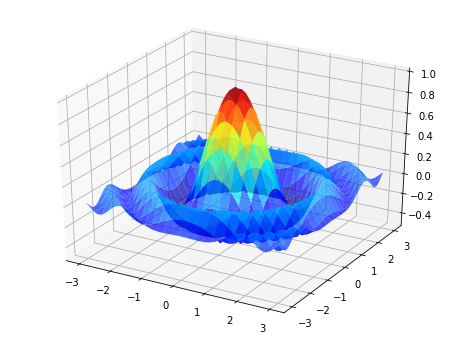

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

xgrid = np.linspace(-3, 3, 50)
ygrid = xgrid
x, y = np.meshgrid(xgrid, ygrid)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x,
                y,
                f(x, y),
                rstride=2, cstride=2,
                cmap=cm.jet,
                alpha=0.7,
                linewidth=0.25)
ax.set_zlim(-0.5, 1.0)
plt.show()

In [7]:
#To maximize it, we’re going to use a naive grid search:

#1.Evaluate f for all (x,y) in a grid on the square
#2.Return the maximum of observed values
#Here’s a non-vectorized version that uses Python loops
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
m = -np.inf

qe.tic()
for x in grid:
    for y in grid:
        z = f(x, y)
        if z > m:
            m = z

qe.toc()

TOC: Elapsed: 0:00:3.51


3.518805980682373

In [11]:
#And here’s a vectorized version
def f(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

qe.tic()
np.max(f(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.02


0.02638530731201172

#Pros and Cons of Vectorization
#At its best, vectorization yields fast, simple code

#However, it’s not without disadvantages

#One issue is that it can be highly memory intensive

#For example, the vectorized maximization routine above is far more memory intensive than the non-vectorized version that preceded it

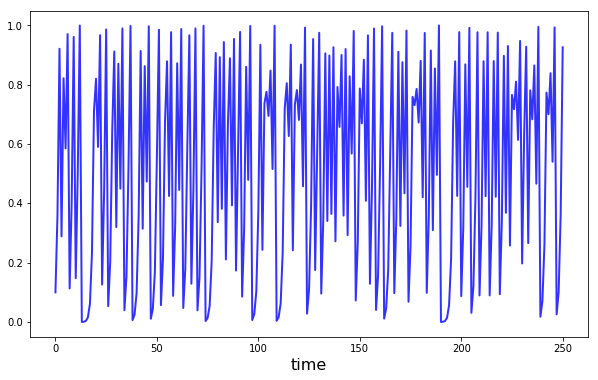

In [14]:
#Numba
#Let’s consider some problems that are difficult to vectorize
#One is generating the trajectory of a difference equation given an initial condition
#Let’s take the difference equation to be the quadratic map

#xt+1=4xt(1−xt)
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x

x = qm(0.1, 250)
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(x, 'b-', lw=2, alpha=0.8)
ax.set_xlabel('time', fontsize=16)
plt.show()

In [15]:
from numba import jit

qm_numba = jit(qm)  # qm_numba is now a 'compiled' version of qm
qe.util.tic()
qm(0.1, int(10**5))
time1 = qe.util.toc()


TOC: Elapsed: 0:00:0.10


In [16]:
#The first execution is relatively slow because of JIT compilation (see below)

#Next time and all subsequent times it runs much faster:
qe.util.tic()
qm_numba(0.1, int(10**5))
time2 = qe.util.toc()

TOC: Elapsed: 0:00:0.09


In [17]:
qe.util.tic()
qm_numba(0.1, int(10**5))
time2 = qe.util.toc()

TOC: Elapsed: 0:00:0.00


In [18]:
time1 / time2

232.8657505285412

In [19]:
#If you don’t need a separate name for the “numbafied” version of qm, you can just put @jit before the function
@jit
def qm(x0, n):
    x = np.empty(n+1)
    x[0] = x0
    for t in range(n):
        x[t+1] = 4 * x[t] * (1 - x[t])
    return x
#This is equivalent to qm = jit(qm)


qe.util.tic()
qm(0.1, int(10**5))
time1 = qe.util.toc()



TOC: Elapsed: 0:00:0.08


In [20]:
qe.util.tic()
qm(0.1, int(10**5))
time1 = qe.util.toc()



TOC: Elapsed: 0:00:0.00


In [21]:
#A Gotcha: Global Variables
a = 1

@jit
def add_x(x):
    return a + x

print(add_x(10))

11


In [22]:
a = 2

print(add_x(10))

#Notice that changing the global had no effect on the value returned by the function

#When Numba compiles machine code for functions, it treats global variables as constants to ensure type stability


11


In [23]:
#Numba for vectorization
##This is faster than our vectorized version using NumPy’s ufuncs
from numba import vectorize

@vectorize
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

grid = np.linspace(-3, 3, 1000)
x, y = np.meshgrid(grid, grid)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.01


0.018646955490112305

In [24]:
#We can gain further speed improvements using Numba’s automatic parallelization feature by specifying target=’parallel’
@vectorize('float64(float64, float64)', target='parallel')
def f_vec(x, y):
    return np.cos(x**2 + y**2) / (1 + x**2 + y**2)

np.max(f_vec(x, y))  # Run once to compile

qe.tic()
np.max(f_vec(x, y))
qe.toc()

TOC: Elapsed: 0:00:0.00


0.008961915969848633